![STScI Logo](../../../_static/stsci_header.png)

<a id="titleReduction"></a>
# ACS/WFC Image Reduction

This notebook covers the steps necessary to calibrate Advanced Camera for Surveys (ACS) Wide Field Channel (WFC) observations to produce a distortion-corrected image ready for photometry.

## Table of Contents

[Introduction](#intro_ID) <br>
[1. Imports](#imports) <br>
[2. Download the Data ](#_download) <br>
[3. File Information](#file) <br>
[4. Calibrate Raw Files](#_calibrate) <br>
[5. Conclusion](#conclusion) <br>
[About this Notebook](#about)


<a id="intro_ID"></a>
## Introduction

For most observations, reprocessing the raw files with the calibration pipeline is no longer required as the [MAST](http://archive.stsci.edu) archive is now static and any changes to the pipeline or reference files automatically triggers a reprocessing of the data. However, users may wish to reprocess their data with custom reference files.

This notebook is intended for users with a (very!) basic understanding of python and photometry. 

You will need approximately **13 GB of space** available for this exercise.


### This tutorial will show you how to...

#### 1. [Calibrate Raw Files](#_calibrate) 

* Query the Calibration Reference Data System ([CRDS](https://hst-crds.stsci.edu/)) for the current best reference files applicable to a given observation
* Update the `*_raw.fits` primary headers with new calibration information
* Retrieve calibration files from CRDS and set up the reference file directory
* Process files with `calacs`

#### 2. [Update the WCS](#_wcs) 

* Update the FLT/FLC file WCS header keywords

<a id="imports"></a>
## 1. Imports

Here we list the Python packages used in this notebook. Links to the documentation for each module is provided for convenience.

| Package Name     | module           | docs          | used for    |
|------------------|:-----------------|:-------------:|:------------|
| `os`             | `system`           | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.system">link</a>|command line input|
| `os`             | `environ`          | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.environ">link</a>| setting environments |
|`shutil`          | `rmtree`           | <a class="divlink" href="https://docs.python.org/2/library/shutil.html#shutil.rmtree">link</a>| remove directory tree |
|`glob`            | `glob`             | <a class="divlink" href="https://docs.python.org/2/library/glob.html#glob.glob">link</a>| search for files based on Unix shell rules |
|`astroquery.mast` |`Observations`      | <a class="divlink" href="https://astroquery.readthedocs.io/en/latest/mast/mast.html">link</a>| download data from MAST |
|`astropy.io`      | `fits`             | <a class="divlink" href="http://docs.astropy.org/en/stable/io/fits/">link</a>| access and update fits files |
|`astropy.table`   | `Table`            | <a class="divlink" href="http://docs.astropy.org/en/stable/table/">link</a>| constructing and editing in a tabular format |
|`stwcs`           |`updatewcs`         | <a class="divlink" href="https://stwcs.readthedocs.io/en/latest/updatewcs_ui.html">link</a>| update wcs solution |

In [1]:
import os
import shutil
import glob

from astroquery.mast import Observations

from astropy.io import fits

from stwcs import updatewcs

from p_module import plot

<a id="_download"></a>
## 2. Download the Data 

Here we download all of the data required for this notebook. This is an important step! Some of the image processing steps require all relevant files to be in the working directory. We recommend working with a brand new directory for every new set of data.

### [GO Proposal 10775](https://stdatu.stsci.edu/proposal_search.php?mission=hst&id=10775): "An ACS Survey of Galactic Globular Clusters"

For this example, we will only retreive data associated with the Observation ID **J9L960010**. Using the python package `astroquery`, we can access the [MAST](http://archive.stsci.edu) archive. 

We will need to grab the raw files, the telemetry files, and the association file for this observation set.

<div class="alert alert-danger">
<b>MAY CHANGE:</b> The argument "mrp_only" stands for "minimum recommended products only". It currently needs to be set to False, although in the future, False is intended to be set as the default and can be left out.
</div>

In [2]:
obs_table = Observations.query_criteria(proposal_id=10775, obs_id='J9L960010')


dl_table = Observations.download_products(obs_table['obsid'],
                                          productSubGroupDescription=['RAW', 'ASN', 'SPT'],
                                          mrp_only=False)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


We'll use the packages `os` and `shutil` to put all of these files in our working directory and do a little housekeeping.

In [3]:
for row in dl_table:
    oldfname = row['Local Path']
    newfname = os.path.basename(oldfname)
    os.rename(oldfname, newfname)
    
# Delete the mastDownload directory and all subdirectories it contains.
shutil.rmtree('mastDownload')

Here we set our filenames to variable names for convenience using `glob.glob`.

In [4]:
asn_file = 'j9l960010_asn.fits'
raw_files = glob.glob('*_raw.fits')

<a id="file"></a>
## 3. File Information

The structure of the fits files from ACS may be different depending on what kind of observation was made. For more information, refer to Section 2.2 of the [ACS Data Handbook](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/other-documents/_documents/acs_dhb.pdf).

### Association Files

| Ext    | Name             | Type         | Contains                                               |
|--------|------------------|--------------|:-------------------------------------------------------|
|<b>0</b>| PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                  |
|<b>1</b>| ASN (Association)| (BinTableHDU)| Table of files associated with this group.             |

### Raw Files (WFC-Specific)

| Ext    | Name             | Type         | Contains                                               |
|--------|------------------|--------------|:-------------------------------------------------------|
|<b>0</b>| PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                  |
|<b>1</b>| SCI (Image)      | (ImageHDU)   | WFC2 raw image data.                                   |
|<b>2</b>| ERR (Error)      | (ImageHDU)   | WFC2 error array.                                      |
|<b>3</b>| DQ (Data Quality)| (ImageHDU)   | WFC2 data quality array.                               |
|<b>4</b>| SCI (Image)      | (ImageHDU)   | WFC1 raw image data.                                   |
|<b>5</b>| ERR (Error)      | (ImageHDU)   | WFC1 error array.                                      |
|<b>6</b>| DQ (Data Quality)| (ImageHDU)   | WFC1 data quality array.                               |

You can always use `.info()` on an HDUlist for an overview of the structure

In [5]:
with fits.open(asn_file) as hdulist:
    hdulist.info()
    
with fits.open(raw_files[0]) as hdulist:
    hdulist.info()

Filename: j9l960010_asn.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  ASN           1 BinTableHDU     25   6R x 3C   [14A, 14A, L]   


Filename: j9l960a9q_raw.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     223   ()      
  1  SCI           1 ImageHDU        97   (4144, 2068)   int16 (rescales to uint16)   
  2  ERR           1 ImageHDU        49   ()      
  3  DQ            1 ImageHDU        41   ()      
  4  SCI           2 ImageHDU        97   (4144, 2068)   int16 (rescales to uint16)   
  5  ERR           2 ImageHDU        49   ()      
  6  DQ            2 ImageHDU        43   ()      


In [6]:
!conda list hstcal

# packages in environment at /home/runner/micromamba/envs/ci-env:
#
# Name                     Version          Build            Channel
hstcal                     3.1.0            h032429d_3       conda-forge


## 4. Calibrate Raw Files <a id="_calibrate"></a>

Now that we have the `*_raw.fits` files, we can process them with the ACS calibration pipeline `calacs`. 

### Updating Headers for CRDS

By default, the association file will trigger the creation of a drizzled product. In order to avoid this, we will filter the association file to only include table entries with `MEMTYPE` equal to 'EXP-DTH'. This will remove the 'PROD-DTH' entry that prompts AstroDrizzle.

In [7]:
with fits.open(asn_file, mode='update') as asn_hdu:
    asn_tab = asn_hdu[1].data
    asn_tab = asn_tab[asn_tab['MEMTYPE'] == 'EXP-DTH']

Due to the computationally intense processing required to CTE correct full-frame ACS/WFC images, we have disabled the CTE correction here by default, however it can be turned on by changing the following variable to True:

In [8]:
cte_correct = False

Calibration steps can be enabled or disabled by setting the switch keywords in the primary header to 'PERFORM' or 'OMIT', respectively. Switch keywords  all end with the string `CORR` (e.g., `BLEVCORR` and `DARKCORR`). In this case, we want to update `PCTECORR`.

In [9]:
for file in raw_files:
    
    if cte_correct: 
        value = 'PERFORM'
    else: 
        value = 'OMIT'
        
    fits.setval(file, 'PCTECORR', value=value)

### Querying CRDS for Reference Files

Before running `calacs`, we need to set some environment variables for several subsequent calibration tasks.

We will point to a subdirectory called `crds_cache/` using the JREF environment variable. The `JREF` variable is used for ACS reference files. Other instruments use other variables, e.g., `IREF` for WFC3.

In [10]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['jref'] = './crds_cache/references/hst/acs/'

The code block below will query CRDS for the best reference files currently available for these datasets, update the header keywords to point "to these new files. We will use the Python package `os` to run terminal commands. In the terminal, the line would be:

    crds bestrefs --files [filename] --sync-references=1 --update-bestrefs
    
...where 'filename' is the name of your fits file.

In [11]:
for file in raw_files:
    !crds bestrefs --files {file} --sync-references=1 --update-bestrefs

CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing j9l960a9q_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing j9l960afq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing j9l960abq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing j9l960adq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing j9l960a7q_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


### Running calacs

Finally, we can run `calacs` on the association file. It will produce `*_flt.fits`. The FLT files have had the default CCD calibration steps (bias subtraction, dark subtraction, flat field normalization) performed.

<div class="alert alert-block alert-info"><b>If the CTE correction is enabled...</b>

   * ...this next step will take a long time to complete. The CTE correction is computationally expensive and will use all of the cores on a machine by default. On an 8 core machine, CTE correcting a full-frame ACS/WFC image can take approximately 15 minutes per RAW file. 
   

   * ...`*_flc.fits` will also be produced.  The FLC files are CTE-corrected but otherwise identical to the FLT files.
</div>

In [12]:
!calacs.e j9l960010_asn.fits

git tag: 0090c701-dirty
git branch: HEAD
HEAD @: 0090c701d894003cfc690e9f8d5fde81e6939090
Setting max threads to 4 out of 4 available


CALBEG*** CALACS -- Version 10.4.0 (07-May-2024) ***
Begin    19-Nov-2025 18:51:55 UTC


Input    j9l960010_asn.fits
LoadAsn:  Processing FULL Association
Trying to open j9l960010_asn.fits...
Read in Primary header from j9l960010_asn.fits...


CALBEG*** ACSCCD -- Version 10.4.0 (07-May-2024) ***
Begin    19-Nov-2025 18:51:55 UTC
Input    j9l960a7q_raw.fits
Output   j9l960a7q_blv_tmp.fits
Trying to open j9l960a7q_raw.fits...
Read in Primary header from j9l960a7q_raw.fits...
APERTURE WFCENTER
FILTER1 F606W
FILTER2 CLEAR2L
DETECTOR WFC




CCDTAB   jref$72m1821ij_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table
CCDTAB   DESCRIP =June 2002


DQICORR  PERFORM
DQITAB   jref$25g1256nj_bpx.fits
DQITAB   PEDIGREE=INFLIGHT 30/03/2002 30/05/2002
DQITAB   DESCRIP =FITS reference table for bad pixel locations on ACS WFC
DQICORR  COMPLETE


BIASCORR PERFORM
BIASFILE jref$66318264j_bia.fits
BIASFILE PEDIGREE=INFLIGHT 05/03/2006 24/03/2006
BIASFILE DESCRIP =Standard full-frame bias for data taken after Mar 04 2006 08:00:00-


BIASCORR COMPLETE


BLEVCORR PERFORM
OSCNTAB  jref$17717071j_osc.fits
OSCNTAB  PEDIGREE=GROUND
OSCNTAB  DESCRIP =New OSCNTAB which includes entries for all subarrays.--------------
(blevcorr) No virtual overscan region specified.
(blevcorr) Bias drift correction will not be applied.
(FitToOverscan) biassecta=(18,23) biassectb=(0,0) npix=6
(blevcorr) Rejected 0 bias values from fit.
Computed a fit with slope of -0.000106303 and intercept of 4590.19


(FitToOverscan) biassecta=(4120,4125) biassectb=(0,0) npix=6
(blevcorr) Rejected 6 bias values from fit.
Computed a fit with slope of 0.000173842 and intercept of 4499.48
Bias level from overscan has been subtracted;
     mean of bias levels subtracted was 4544.83 electrons.
     bias level of 4590.19 electrons was subtracted for AMP C.
     bias level of 4499.48 electrons was subtracted for AMP D.
(blevcorr) No virtual overscan region specified.
(blevcorr) Bias drift correction will not be applied.
(FitToOverscan) biassecta=(18,23) biassectb=(0,0) npix=6
(blevcorr) Rejected 6 bias values from fit.
Computed a fit with slope of -0.00016778 and intercept of 4534.42
(FitToOverscan) biassecta=(4120,4125) biassectb=(0,0) npix=6
(blevcorr) Rejected 6 bias values from fit.
Computed a fit with slope of -7.68968e-05 and intercept of 4529.01
Bias level from overscan has been subtracted;
     mean of bias levels subtracted was 4531.71 electrons.
     bias level of 4534.41 electrons was subtracted

Full-frame full-well saturation image flagging step being performed.

Full-frame full-well saturation image flagging step done.


Full-well saturation flagging being performed for imset 2.



Full-frame full-well saturation image flagging step being performed.

Full-frame full-well saturation image flagging step done.


    Uncertainty array initialized,
    readnoise =5.33,4.99,5.51,5.16
    gain =2.002,1.945,2.028,1.994
   default bias levels =4535.7,4535.7,4590.2,4498.9


SINKCORR OMIT




End      19-Nov-2025 18:51:56 UTC


*** ACSCCD complete ***


CALBEG*** ACS2D -- Version 10.4.0 (07-May-2024) ***
Begin    19-Nov-2025 18:51:56 UTC
Input    j9l960a7q_blv_tmp.fits
Output   j9l960a7q_flt.fits
Warning    Output file `j9l960a7q_flt.fits' already exists.
ERROR:    Couldn't process CCD data
ERROR:    CALACS processing NOT completed for j9l960010_asn.fits
ERROR:    CALACS processing NOT completed for j9l960010_asn.fits
ERROR:             status = 1021


Selecting an image to plot, depending on whether or not you enabled CTE correction earlier.

In [13]:
if cte_correct:
    fl_fits = 'j9l960a7q_flc.fits'
else:
    fl_fits = 'j9l960a7q_flt.fits'

### Plotting results

As a check of our calibrated products, we will plot a subsection of one of the input images.

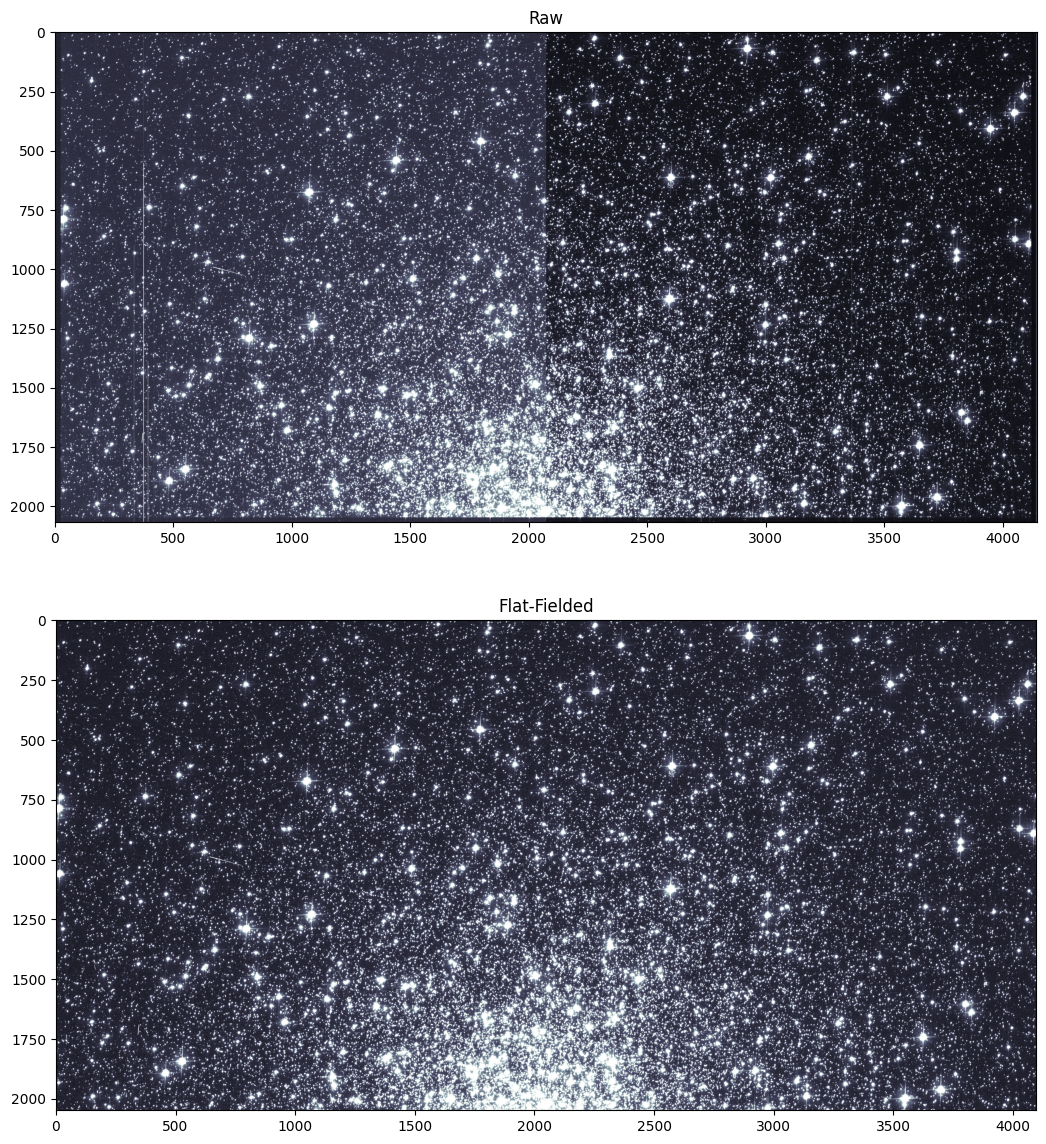

In [14]:
raw_image = fits.getdata('j9l960a7q_raw.fits')
cal_image = fits.getdata(fl_fits)

plot.calib_compare_plot(raw_image, cal_image)

Comparing the FLT calibrated image to the RAW uncalibrated one, we can see that image artifacts have been removed. Most noticeably, hot columns in the bias have been subtracted.

In [15]:
if cte_correct:
    img_files = 'j9l9*a[9-f]q_flc.fits'
else:
    img_files = 'j9l9*a[9-f]q_flt.fits'

updatewcs.updatewcs(img_files, use_db=False)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Using 2015-calibrate

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Using 2015-calibrate

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Using 2015-calibrate

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
Using 2015-calibrate

['j9l960afq_flt.fits',
 'j9l960adq_flt.fits',
 'j9l960abq_flt.fits',
 'j9l960a9q_flt.fits']

<a id="conclusion"></a>
## 5. Conclusion

The FLT and FLC images are not yet suitable for photometry. Before performing any analysis on the images, we still need to remove detector artifacts, cosmic rays, and geometric distortion. [AstroDrizzle](http://www.stsci.edu/scientific-community/software/drizzlepac.html) can do all of these steps and produce a single mosaic image that incorporates all of the individual exposures.

Users who do not use `astrodrizzle` to correct data for distortion will need to apply a pixel area map to their data to correct for the distorted pixel area projected onto the sky before performing photometry. For those who would like to learn how to create a pixel area map, a Jupyter Notebook on the subject can be found [here](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/ACS/acs_pixel_area_maps/acs_pixel_area_maps.ipynb).

<a id="about"></a>
# About this Notebook
**Curator:** Jenna Ryon, ACS Instrument Team, Space Telescope Science Institute 

### For more help:

More details may be found on the [ACS website](http://www.stsci.edu/hst/instrumentation/acs) and in the [ACS Instrument](https://hst-docs.stsci.edu/display/ACSIHB) and [Data Handbooks](https://hst-docs.stsci.edu/acsdhb).

Please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the HST Knowledge Base and request additional help from experts.

<hr>

[Top of Page](#titleReduction)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 